In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PolicyNetwork(nn.Module):
    def __init__(self, n, m):
        super(PolicyNetwork, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)

        # Calculate the size of the grid after convolutional and pooling layers
        conv_output_size = ((n - 1) // 2 // 2 + 1) * ((m - 1) // 2 // 2 + 1) * 64

        # Fully connected layers
        self.fc1 = nn.Linear(conv_output_size + 2, 128)  # +2 for block width and height
        self.fc2 = nn.Linear(128, n * m)

    def forward(self, x, block_width, block_height):
        # Convolutional layers with ReLU and max pooling
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv3(x))

        # Flatten the convolutional layer output
        x = x.view(x.size(0), -1)


        # Retrieve the device from x
        device = x.device

        # Create block_dims tensor and move it to the same device as x
        # block_dims = torch.tensor([block_width, block_height], dtype=torch.float32).view(1, -1)
        block_dims = torch.tensor([block_width, block_height], dtype=torch.float32, device=device).view(1, -1)

        # Concatenate block dimensions
        x = torch.cat((x, block_dims), dim=1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        # Output layer with softmax for probability distribution
        return F.softmax(x.view(-1, n, m), dim=1)  # Reshape to n x m grid

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

import torch.nn.functional as F
from torch.distributions import Bernoulli
from torch.autograd import Variable
from itertools import count
import matplotlib.pyplot as plt
import torch.distributions as dist

from copy import deepcopy
from torch.utils.data import DataLoader, TensorDataset
import random

import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [ ]:
class ShapePlacementEnv:
    def __init__(self, grid_size, shapes):
        """
        Initialize the environment.
        :param grid_size: Tuple (n, m) representing the size of the grid.
        :param shapes: List of tuples representing the shapes to be placed.
        """
        self.grid_size = grid_size
        self.shapes = shapes
        self.reset()

    def reset(self):
        """
        Reset the environment for a new episode.
        :return: The initial state of the environment.
        """
        self.grid = np.zeros(self.grid_size)
        self.current_shape_index = 0
        return self.grid

    def step(self, action):
        """
        Take an action in the environment.
        :param action: Tuple (x, y) representing where to place the current shape.
        :return: (next_state, reward, done)
        """
        reward = 0
        done = False

        shape = self.shapes[self.current_shape_index]
#         if self._can_place_shape(action, shape):
#             self._place_shape(action, shape)
#             reward = 1  # Example reward for successful placement
#         else:
#             reward = -1  # Example penalty for unsuccessful placement

        self._place_shape(action, shape)

        self.current_shape_index += 1
        if self.current_shape_index >= len(self.shapes):
            done = True  # End of episode

        return self.grid, done

    def _can_place_shape(self, position, shape):
        """
        Check if a shape can be placed at the given position.
        """
        x, y = position
        shape_width, shape_height = shape
        if x + shape_width > self.grid_size[0] or y + shape_height > self.grid_size[1]:
            return False

        # Check for overlap
        for i in range(x, x + shape_width):
            for j in range(y, y + shape_height):
                if self.grid[i, j] == 1:
                    return False

        return True

    def _place_shape(self, position, shape):
        """
        Place a shape on the grid at the given position.
        """
        x, y = position
        shape_width, shape_height = shape
        for i in range(x, min(self.grid_size[0], x + shape_width)):
            for j in range(y, min(self.grid_size[1], y + shape_height)):
                self.grid[i, j] += 1

In [ ]:
def get_coords(probabilities, n, m):
    probabilities = probabilities.squeeze()  # Remove batch dimension if batch_size is 1
    probabilities = probabilities.view(-1)
    categorical = dist.Categorical(probs=probabilities)
    #categorical = dist.Bernoulli(probs=output_probabilities)

    # Sample an action from the distribution
    sampled_index = categorical.sample().item()
    row = sampled_index // m
    col = sampled_index % m
#     print(f"Sampled action: {sampled_index}")
    return [row, col]

In [ ]:
n, m =64, 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
policy_net = PolicyNetwork(n, m).to(device)

cuda


In [ ]:
policy_net.load_state_dict(torch.load('policy_net'))

<All keys matched successfully>

In [ ]:
import numpy as np
# train_data = np.load('train_data.npy', allow_pickle=True, encoding='latin1')
# print(train_data.shape)

shape_data = np.load('shape_data.npy', allow_pickle=True, encoding='latin1')
print(shape_data.shape)

factor=100.0

for i in range(len(shape_data)):
    shape_data[i] = [shape_data[i][0]/factor, shape_data[i][1]/factor]

# for i in range(len(train_data)):
#     for j in range(len(train_data[i])):
#         train_data[i][j] = [max(1, int(train_data[i][j][0]/factor)), max(1, int(train_data[i][j][1]/factor))]

# train_final = np.load('train_final.npy', allow_pickle=True, encoding='latin1')

(49, 2)


In [ ]:
n, m = 64, 64

# Use an existing policy network or create a new one
policy_net_curr = policy_net.to(device)  # Assuming policy_net is defined and is an instance of PolicyNetwork
total_shapes = 9
final_coords = []
final_images = []
for i in range(total_shapes):
    env1 = ShapePlacementEnv((n, m), shape_data)

    state = env1.reset()
    state = torch.from_numpy(state).float().to(device)

    curr_coords = []
    steps = 0
    for t in count():
        print('index', env1.current_shape_index)
        shape_index = env1.current_shape_index
        width, height = shape_data[shape_index]
        width, height = torch.tensor([width], device=device), torch.tensor([height], device=device)

        # Ensure state is a tensor on the correct device
        state = state.unsqueeze(0).unsqueeze(0)

        probs = policy_net_curr(state, width, height)
        action = get_coords(probs, n, m)
        print('action', action, 'width', width, 'height', height)
        curr_coords.append(action)

        next_state, done = env1.step(action)

        state = torch.from_numpy(next_state).float().to(device)

        if done:
            reward = 0
            break

        steps += 1
    final_images.append(state)
    final_coords.append(curr_coords)


index 0
action [15, 41] width tensor([32], device='cuda:0') height tensor([17], device='cuda:0')
index 1
action [27, 55] width tensor([15], device='cuda:0') height tensor([6], device='cuda:0')
index 2
action [15, 27] width tensor([21], device='cuda:0') height tensor([10], device='cuda:0')
index 3
action [31, 35] width tensor([16], device='cuda:0') height tensor([30], device='cuda:0')
index 4
action [59, 11] width tensor([5], device='cuda:0') height tensor([13], device='cuda:0')
index 5
action [55, 10] width tensor([18], device='cuda:0') height tensor([8], device='cuda:0')
index 6
action [10, 49] width tensor([8], device='cuda:0') height tensor([3], device='cuda:0')
index 7
action [30, 37] width tensor([12], device='cuda:0') height tensor([6], device='cuda:0')
index 8
action [14, 59] width tensor([9], device='cuda:0') height tensor([4], device='cuda:0')
index 9
action [32, 4] width tensor([6], device='cuda:0') height tensor([2], device='cuda:0')
index 10
action [14, 39] width tensor([8]

In [ ]:
# def generate_images_from_files(curr_coords, shape_data):
#     fig, ax = plt.subplots(figsize=(15, 15))  # Create a single subplot

#     for index in range(len(shape_data)):
#         print(index)
#         x, y = curr_coords[index]
#         width, height = shape_data[index]
#         direction = 'N'  # Default direction

#         # Adjust width and height based on the direction
#         if direction in ['W', 'E', 'FE', 'FW']:
#             width, height = height, width

#         rect = patches.Rectangle((x, y), width, height, fill=True, edgecolor='black')
#         ax.add_patch(rect)

#         # Add text indicating the direction
#         ax.text(x + width / 2, y + height / 2, direction, ha='center', va='center', color='white')

#     # Set axis limits and properties
#     ax.set_xlim(0, 85)  # Adjusted axis limits
#     ax.set_ylim(0, 70)
#     ax.set_aspect('equal', 'box')
#     ax.set_title("ami49")

#     plt.show()

# # Example usage
# generate_images_from_files(final_coords[1], shape_data)

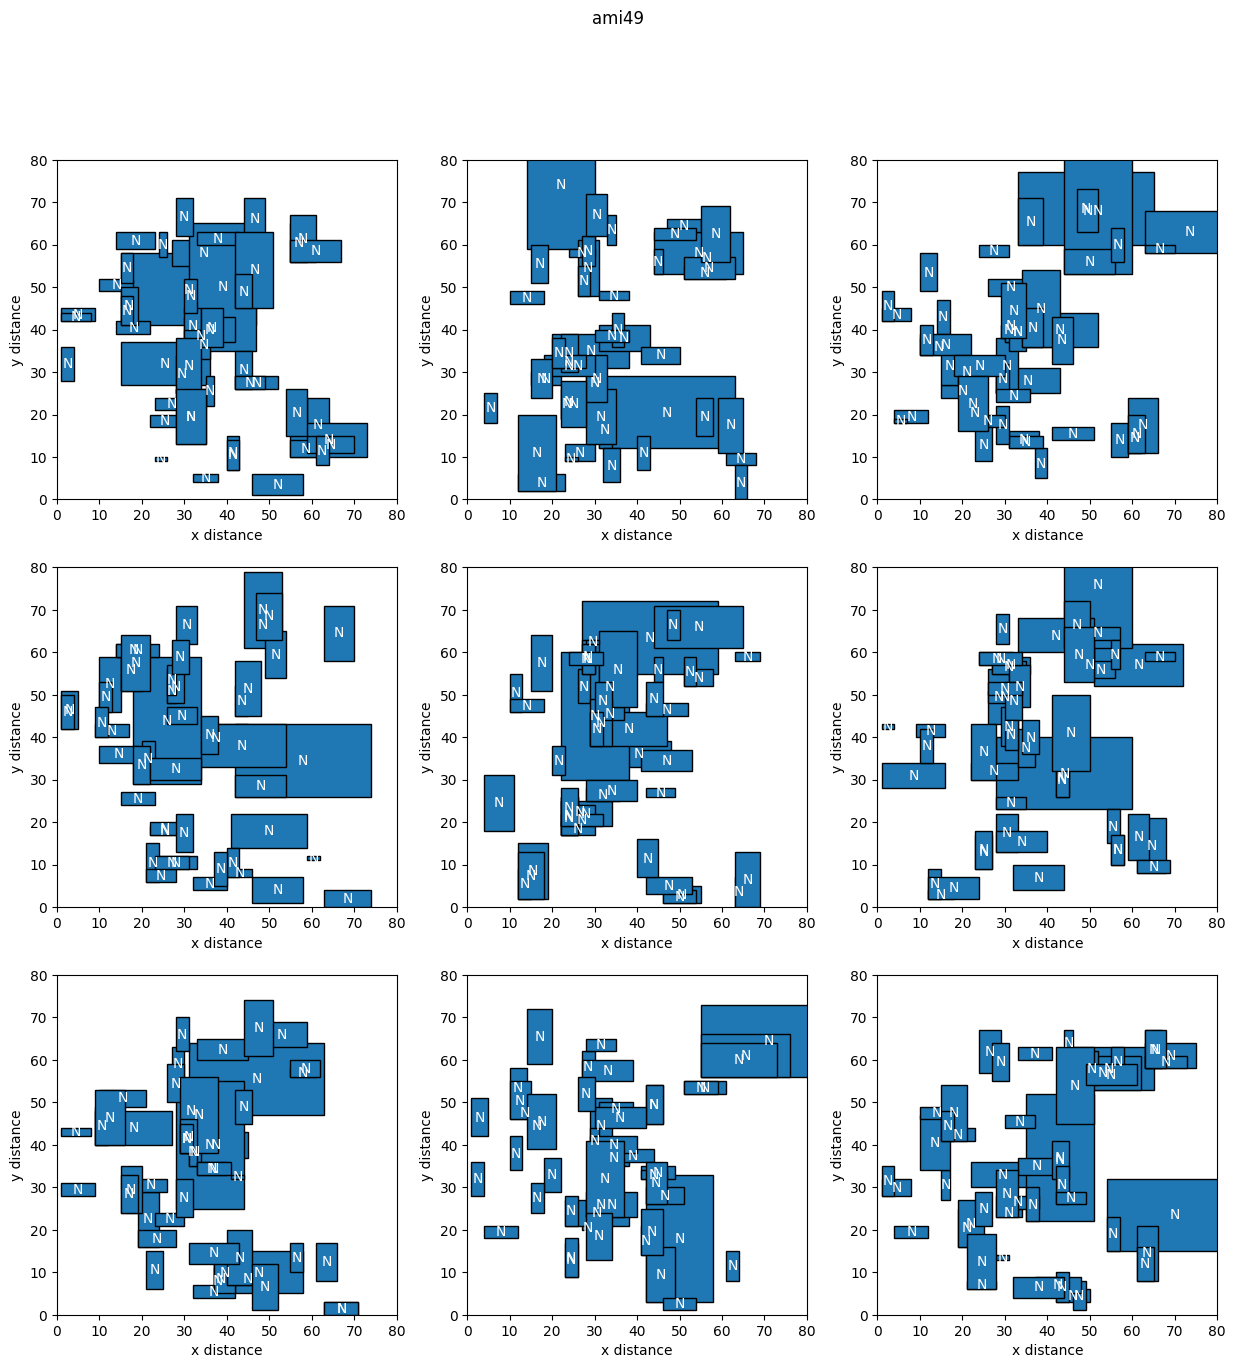

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def generate_images_from_files(all_curr_coords, shape_data):
    fig, axs = plt.subplots(3, 3, figsize=(15, 15))  # Create a 3x3 grid of subplots

    for i in range(3):
        for j in range(3):
            ax = axs[i, j]
            curr_coords = all_curr_coords[i*3 + j]  # Get the current set of coordinates

            for index in range(len(shape_data)):
                x, y = curr_coords[index]
                width, height = shape_data[index]
                direction = 'N'  # Default direction

                # Adjust width and height based on the direction
                if direction in ['W', 'E', 'FE', 'FW']:
                    width, height = height, width

                rect = patches.Rectangle((x, y), width, height, fill=True, edgecolor='black')
                ax.add_patch(rect)

                # Add text indicating the direction
                ax.text(x + width / 2, y + height / 2, direction, ha='center', va='center', color='white')

            # Set axis limits and properties for each subplot
            ax.set_xlim(0, 80)
            ax.set_ylim(0, 80)
            ax.set_aspect('equal', 'box')

            # Set x and y labels
            ax.set_xlabel('x distance')
            ax.set_ylabel('y distance')


    plt.suptitle("ami49")  # Super title for the entire figure
    # Adjust the spacing between subplots
    # fig.subplots_adjust(hspace=0.01, wspace=0.09)  # Reducing the horizontal and vertical spacing

    plt.show()


# Example usage
generate_images_from_files(final_coords, shape_data)

In [ ]:
areas = []
ARs = []
whitespaces = []
for image in final_images:
    curr_image = image.flatten()
    utilise_image = curr_image[curr_image!=0]
    blank_image = curr_image[curr_image==0]
    areas.append(utilise_image.shape[0])
    ARs.append(utilise_image.shape[0]/(64*64))
    whitespaces.append(blank_image.shape[0]/(64*64))

In [ ]:
print("areas", areas)
print("ARs",ARs)
print("whitespaces", whitespaces)

areas [1669, 1722, 1340, 1785, 1572, 1672, 1775, 1565, 1641]
ARs [0.407470703125, 0.42041015625, 0.3271484375, 0.435791015625, 0.3837890625, 0.408203125, 0.433349609375, 0.382080078125, 0.400634765625]
whitespaces [0.592529296875, 0.57958984375, 0.6728515625, 0.564208984375, 0.6162109375, 0.591796875, 0.566650390625, 0.617919921875, 0.599365234375]


In [ ]:
import statistics
areas_mean, areas_std = statistics.mean(areas), statistics.stdev(areas)
ARs_mean, ARs_std = statistics.mean(ARs), statistics.stdev(ARs)
whitespaces_mean, whitespaces_std = statistics.mean(whitespaces), statistics.stdev(whitespaces)

print("areas", areas_mean, areas_std)
print("ARs", ARs_mean, ARs_std)
print("whitespaces", whitespaces_mean, whitespaces_std)

areas 1637.888888888889 136.03716812368268
ARs 0.3998752170138889 0.033212199248945966
whitespaces 0.6001247829861112 0.033212199248945966
